Multimedia Security and Privacy  
Lea Heiniger  
06.04.2023   
  
  # TP2 : Basic Cryptography and Watermarking
  

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

We start by defining useful functions for image and histogram display.

In [2]:
def display_img(images, labels, rows, cols, cmap = None) :
    ''' function that allows us to display one or more images '''

    axes = []
    fig = plt.figure()

    for i in range(rows * cols) :
        axes.append(fig.add_subplot(rows, cols, i + 1))
        plt.imshow(images[i], cmap)
        plt.title(labels[i])
        plt.axis('off')
    fig.tight_layout()
    plt.show()

def display_histo(histograms, tabs, labels, rows, cols) :
    ''' function that allows us to display one or more histogram '''

    _, axs = plt.subplots(rows, cols, figsize=(20,5))

    for i in range(rows * cols) :
        axs[i].plot(histograms[i], tabs[i])
        axs[i].set_title(labels[i])
    plt.show()

## 1 Encryption

### Exercise 1

In [3]:
def image_permutation(img, permut) :
    ''' function that applies a permutation to an image'''
    
    img_flat = np.reshape(img, (img.shape[0]*img.shape[1], img.shape[2]))

    img_permut = img_flat[permut]
    img_permut = np.reshape(img_permut, img.shape)
    
    return img_permut

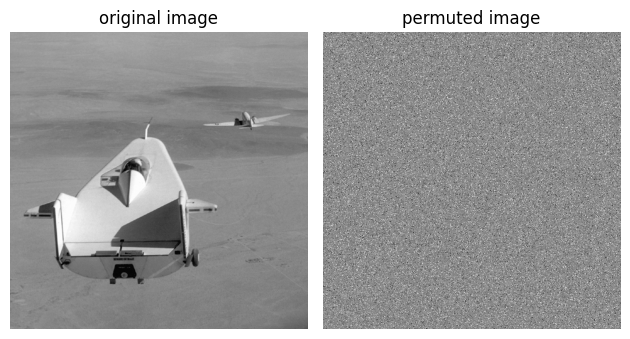

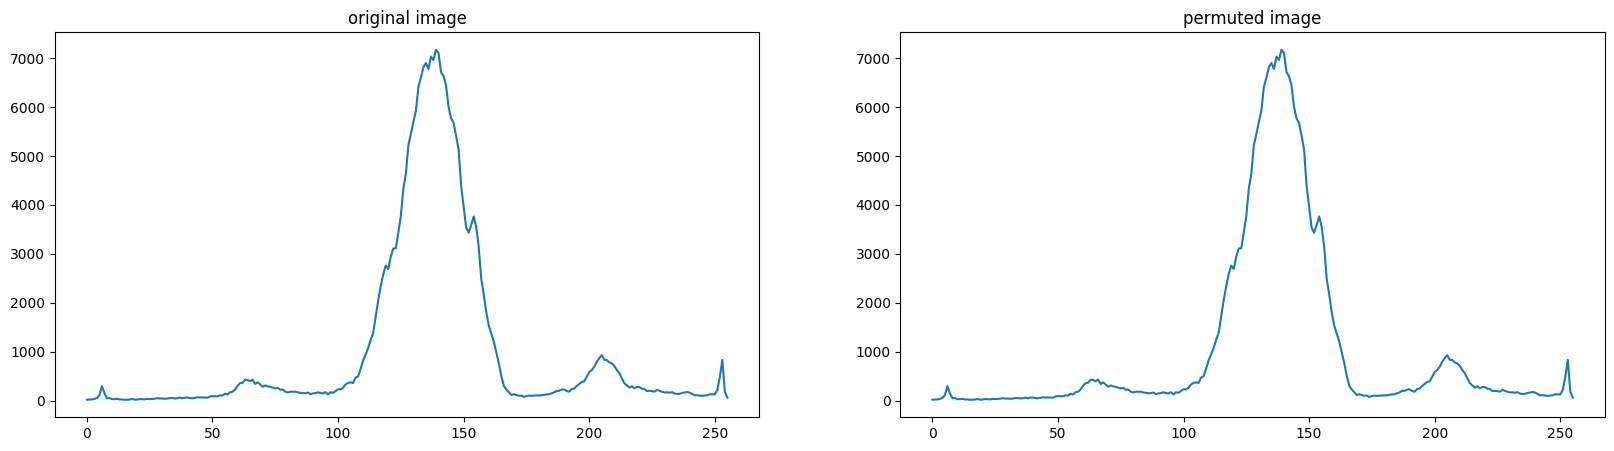

In [4]:
img = cv2.imread("liftingbody.png")
permut = np.random.permutation(img.shape[0]*img.shape[1])

img_permut = image_permutation(img, permut)

images = [img, img_permut]
labels = ["original image", "permuted image"]

display_img(images, labels, 1, 2)

hist = cv2.calcHist([img],[0],None,[256],[0,256])
hist_permut = cv2.calcHist([img_permut],[0],None,[256],[0,256])

histograms = [hist, hist_permut]
tabs = ['tab:blue', 'tab:blue']

display_histo(histograms, tabs, labels, 1, 2)


We can see although the images look completely different, both histograms are identical.  
When we perform a permutation we don't modify the pixels, we just shuffle them. Since the histograms don’t take the pixels position into account it explains the absence of difference.

### Exercise 2


In [5]:
def block_loss(img):
    ''' function that hat models block loss to an image'''
    
    bl_img = np.copy(img)
    
    # coordinates of the top left corner of the block
    block_top_left_cordinates = (random.randint(0,img.shape[0]),random.randint(0,img.shape[1]))
    
    x, y = block_top_left_cordinates
    N = random.randint(0,img.shape[0]-block_top_left_cordinates[0])
    M = random.randint(0,img.shape[1]-block_top_left_cordinates[1])
    
    bl_img[x:x+N, y:y+M, :] = np.zeros((N,M,img.shape[2]))
    
    return bl_img

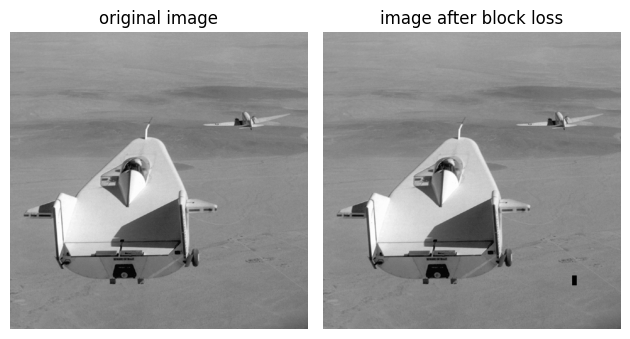

In [6]:
bl_img = block_loss(img)

images = [img, bl_img]
labels = ["original image", "image after block loss"]

display_img(images, labels, 1, 2)

To check that the block loss function is working correctly we applied it on an image and display the result. 

### Exercise 3

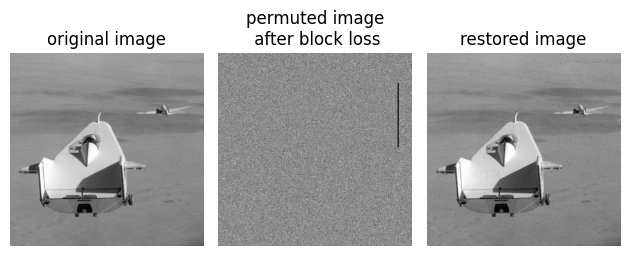

In [7]:
bl_img_permut = block_loss(img_permut)

inv_permut = np.argsort(permut) # inverse permutation
restored_img = image_permutation(bl_img_permut, inv_permut)

images = [img, bl_img_permut, restored_img]
labels = ["original image", "permuted image\n after block loss", "restored image"]

display_img(images, labels, 1, 3)

This time we don’t apply the block loss function to the original image but to a permutation and we perform the inverse permutation.  
The image obtained still looks like the original but with black pixels (that comes from the lost block on the permutation image) spread throughout the image. If the block lost was too big the black noise on the restored image might have been too important for us to bee able to distinguish the image. 
But if the block loss isn’t too important compared to the total size of the image, we have a better result if the block loss happened on the permuted image than if it happened on the original image.

### Exercise 4

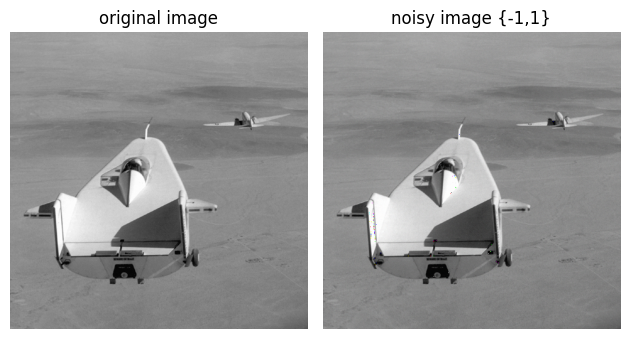

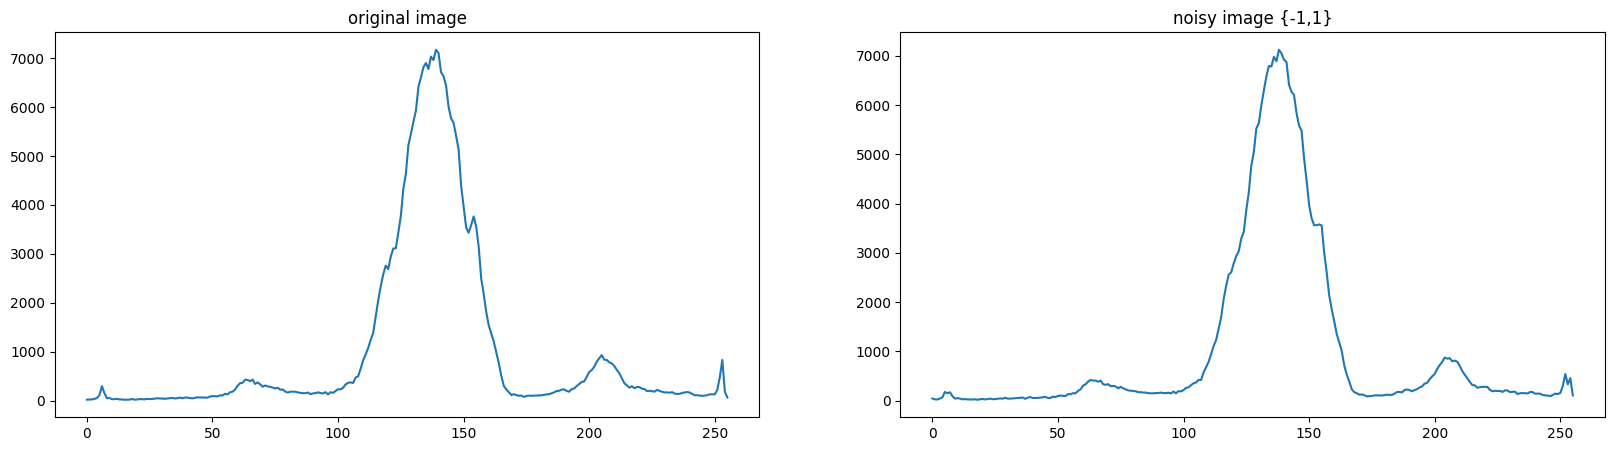

In [8]:
noise1 = np.random.choice([-1,1], img.shape).astype('uint8')
noisy_img1  = np.clip(img+noise1, 0, 255)

images = [img, noisy_img1]
labels = ["original image", "noisy image {-1,1}"]

display_img(images, labels, 1, 2)

hist = cv2.calcHist([img],[0],None,[256],[0,256])
hist_noisy1 = cv2.calcHist([noisy_img1],[0],None,[256],[0,256])

histograms = [hist, hist_noisy1]
tabs = ['tab:blue', 'tab:blue']

display_histo(histograms, tabs, labels, 1, 2)


With small values of noise (barely visible on the images) the variation between the two histograms are small too. And the general shape of the histogram is preserved.

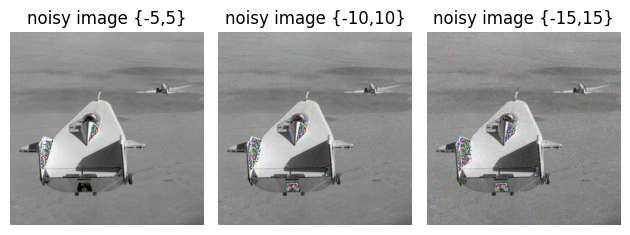

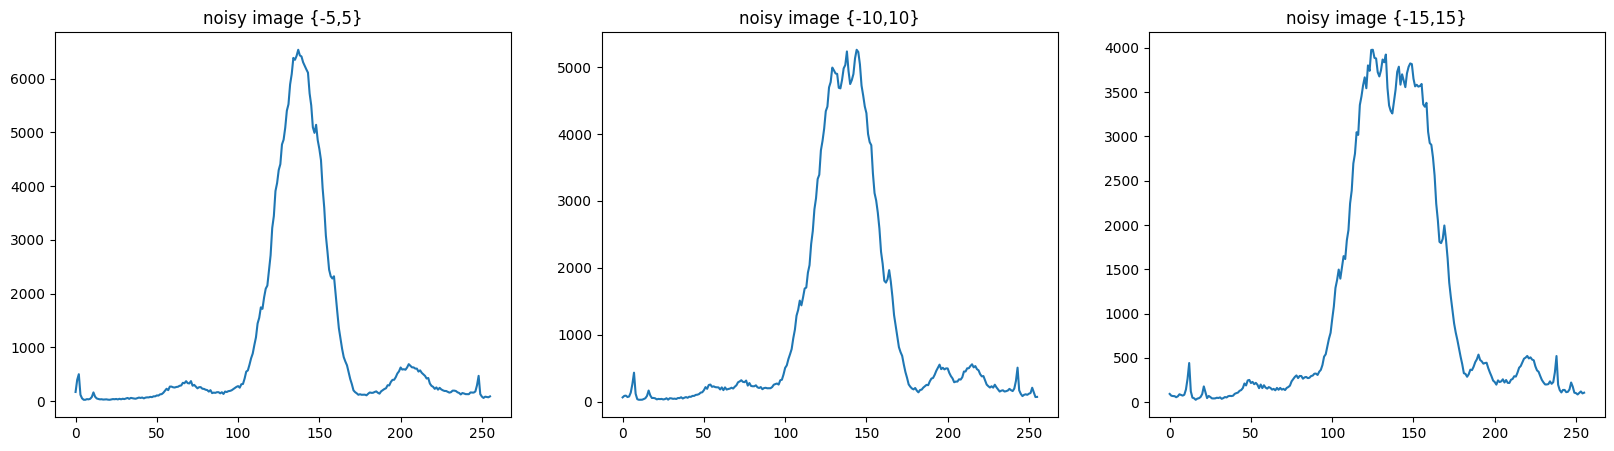

In [9]:

noise5  = 5*noise1 
noisy_img5  = np.clip(img+noise5, 0, 255)

noise10 = 10*noise1 
noisy_img10  = np.clip(img+noise10, 0, 255)

noise15 = 15*noise1 
noisy_img15  = np.clip(img+noise15, 0, 255)

images = [noisy_img5, noisy_img10, noisy_img15]
labels = ["noisy image {-5,5}", "noisy image {-10,10}", "noisy image {-15,15}"]

display_img(images, labels, 1, 3)

hist_noisy5 = cv2.calcHist([noisy_img5],[0],None,[256],[0,256])
hist_noisy10 = cv2.calcHist([noisy_img10],[0],None,[256],[0,256])
hist_noisy15 = cv2.calcHist([noisy_img15],[0],None,[256],[0,256])

histograms = [hist_noisy5, hist_noisy10, hist_noisy15]
tabs = ['tab:blue', 'tab:blue', 'tab:blue']

display_histo(histograms, tabs, labels, 1, 3)

The bigger the added noise values are, the bigger the variations between the histograms are.

In [10]:
def MSE(X, Y) :
    ''' function that computes the Mean Squared Error between X and Y '''
    if X.shape != Y.shape :
        return 0 
    else:
        return np.sum([np.sum([(X[i, j]- Y[i, j])**2 for j in range(X.shape[1])]) for i in range(X.shape[0])]) / (X.shape[0]*X.shape[1])
    
def PSNR(X, Y) :
    ''' function that computes the Peak Signal to Noise Ratio between X and Y '''

    mse = MSE(X,Y)
    if mse == 0:
        return 0
    else:
        return 10 * np.log10(255**2/mse)

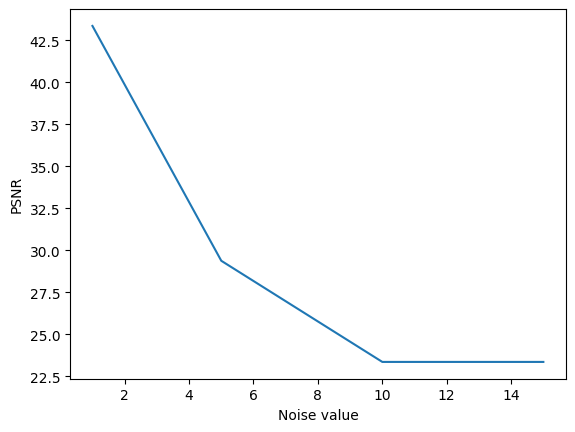

In [11]:
noise = [1,5,10,15]
psnr = [PSNR(img, noisy_img1), PSNR(img, noisy_img5), PSNR(img, noisy_img10), PSNR(img, noisy_img10)]

plt.plot(noise,psnr)
plt.xlabel('Noise value')
plt.ylabel('PSNR')
plt.show()

The graph of PSNR values confirms what we saw on the histograms, with bigger noise values there is a bigger difference between the noisy and the original images (therefore the PSNR is smaller).

## 2 Classical Cryptography

see AES_python.ipynb

## 3 Basic Data Hiding

### Exercise 1


In [12]:
def insert_secret_image(C,S):
    ''' function that insert a secret image S in to tha cover image C'''
    
    C_stego = np.copy(C)
        
    mask_C_R = 0b11111000
    C_R = C[:,:,0] & mask_C_R
    
    mask_C_G = 0b11111100
    C_G = C[:,:,1] & mask_C_G
    
    mask_C_B = 0b11100000
    C_B = C[:,:,2] & mask_C_B
    
    mask_S_R  = 0b11100000
    S_R = S[:,:,0] & mask_S_R
    S_R = S_R >> 5
    
    mask_S_G  = 0b11100000
    S_G = S[:,:,1] & mask_S_G
    S_G = S_G >> 3
    
    mask_S_B_G = 0b11000000
    S_B_G = S[:,:,2] & mask_S_B_G
    S_B_G = S_B_G >> 6
    
    mask_S_B_B = 0b00110000
    S_B_B = S[:,:,2] & mask_S_B_B
    S_B_B = S_B_B >> 4 

    C_stego[:,:,0] = C_R | S_R
    C_stego[:,:,1] = C_G | S_B_G
    C_stego[:,:,2] = C_B | S_G | S_B_B
    
    return C_stego

def recover_secret_image(C_stego):
    '''function that recover the secret image S_recover out of the stegano cover image C_stegano'''
    
    S_recover = np.copy(C_stego)
    
    mask_S_R  = 0b11100000 
    mask_S_R = mask_S_R >> 5
    S_R  = C_stego[:,:,0] & mask_S_R
    S_R  = S_R << 5
    
    mask_S_G  = 0b11100000 
    mask_S_G = mask_S_G >> 3
    S_G  = C_stego[:,:,2] & mask_S_G
    S_G  = S_G << 3
    
    mask_S_B_G = 0b11000000 
    mask_S_B_G = mask_S_B_G >> 6
    S_B_G = C_stego[:,:,1] & mask_S_B_G
    S_B_G = S_B_G << 6
    
    mask_S_B_B = 0b00110000 
    mask_S_B_B = mask_S_B_B >> 4 
    S_B_B = C_stego[:,:,2] & mask_S_B_B
    S_B_B = S_B_B << 4
    
    S_recover[:,:,0] = S_R
    S_recover[:,:,1] = S_G
    S_recover[:,:,2] = S_B_G ^ S_B_B
    
    return S_recover

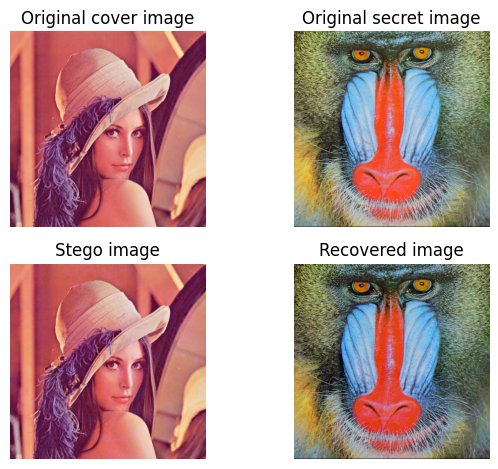

MSE between original cover image and stego image : 83.8052864074707
MSE between original secret image and recovered image : 263.42852783203125


In [13]:
C = cv2.cvtColor(cv2.imread("lena.png"), cv2.COLOR_BGR2RGB)
S = cv2.cvtColor(cv2.imread("baboon.png"), cv2.COLOR_BGR2RGB)

C_stego = insert_secret_image(C,S)
S_recover = recover_secret_image(C_stego)

images = [C, S, C_stego, S_recover]
labels = ["Original cover image", "Original secret image", "Stego image", "Recovered image"]
display_img(images, labels, 2, 2)

print("MSE between original cover image and stego image :", MSE(C, C_stego))
print("MSE between original secret image and recovered image :",MSE(S, S_recover))


We can see that there is no visible difference between the original cover image and the one with the hidden baboon (which is not distinguishable at all in the stego image) and their MSE is still small.  
There is a bit more differences between the two baboon images (the yellowish tones of the fur are a bit more extended on the recovered image) and indeed there MSE is bigger than the one between the other two images. But both images still look a lot alike, the differences are sufficiently negligible to not prevent from understanding the content.